In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
import csv
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms
from torchvision.models import resnet50

In [ ]:
drivepath = "/content/gdrive/MyDrive"

In [ ]:
class KartModel1(nn.Module):
  def __init__(self, class_num = 6):
    super(KartModel1, self).__init__()
    self.class_num = class_num
    self.backbone = resnet50(pretrained=True)
    self.backbone.fc = nn.Sequential(
      nn.Linear(in_features=2048, out_features=class_num, bias=True),
      # nn.Softmax(dim=1)
      nn.Sigmoid()
    )
  
  def forward(self, input_image):
    output = self.backbone(input_image)
    return output

In [ ]:
class KartDataSet(data.Dataset):
  def __init__(self, csv_file):
    self.images = []
    self.labels = []

    with open(csv_file) as csvfile:
      csv_reader = csv.reader(csvfile)
      next(csv_reader, None)
      
      for row in csv_reader:
        self.images.append(drivepath + '/' + row[0])
        self.labels.append([int(x) for x in list(row[1])])

  def __getitem__(self, index):
    image_path = self.images[index]
    image = Image.open(image_path)

    label = self.labels[index]

    preprocess = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
    ])
    
    return preprocess(image), torch.Tensor(label)

  def __len__(self):
    return len(self.images)

In [ ]:
dataset = KartDataSet(drivepath + "/csv/kart_test.csv")
print(dataset[0][0].shape)
print(dataset[0][1])

torch.Size([3, 224, 224])
tensor([0., 0., 0., 0., 0., 0.])


In [ ]:
num_epochs = 20
lr = 1e-4
batch_size = 8
log_interval = 10

device_type = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
print(device)

cuda


In [ ]:
loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=4,
    shuffle=False
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
save_path = drivepath + "/test_model.pt"

model = KartModel1()
model.load_state_dict(torch.load(save_path))

for param, weight in model.named_parameters():
    print(f"param {param:20} required gradient? -> {weight.requires_grad}")
model = model.to(device)

param backbone.conv1.weight required gradient? -> True
param backbone.bn1.weight  required gradient? -> True
param backbone.bn1.bias    required gradient? -> True
param backbone.layer1.0.conv1.weight required gradient? -> True
param backbone.layer1.0.bn1.weight required gradient? -> True
param backbone.layer1.0.bn1.bias required gradient? -> True
param backbone.layer1.0.conv2.weight required gradient? -> True
param backbone.layer1.0.bn2.weight required gradient? -> True
param backbone.layer1.0.bn2.bias required gradient? -> True
param backbone.layer1.0.conv3.weight required gradient? -> True
param backbone.layer1.0.bn3.weight required gradient? -> True
param backbone.layer1.0.bn3.bias required gradient? -> True
param backbone.layer1.0.downsample.0.weight required gradient? -> True
param backbone.layer1.0.downsample.1.weight required gradient? -> True
param backbone.layer1.0.downsample.1.bias required gradient? -> True
param backbone.layer1.1.conv1.weight required gradient? -> True
para

In [ ]:
# criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
scheduler = StepLR(optimizer, 5, gamma=0.5)

In [ ]:
a = 0
for i in loader:
  a = i
  break
  
inputs, labels = a

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AttributeError: ignored

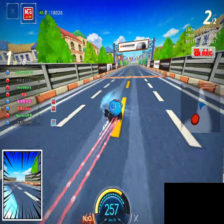

tensor([[0.6684, 0.2650, 0.2120, 0.1272, 0.1036, 0.1047],
        [0.7077, 0.2653, 0.2050, 0.1464, 0.1483, 0.0990],
        [0.6307, 0.2370, 0.2018, 0.1416, 0.1382, 0.1221],
        [0.6427, 0.2262, 0.2046, 0.1436, 0.1364, 0.1023],
        [0.5304, 0.2177, 0.1318, 0.1229, 0.1208, 0.0920],
        [0.4622, 0.2214, 0.1618, 0.1786, 0.1426, 0.1399]],
       grad_fn=<CopyBackwards>)
tensor([[1., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]])
tensor(0.3044, grad_fn=<CopyBackwards>)


In [ ]:
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

display(to_img(inputs[0]))

inputs = inputs.to(device)
labels = labels.to(device)
outs = model(inputs)
print(outs.cpu())
loss = criterion(outs, labels)
print(labels.cpu())
print(loss.cpu())

In [ ]:
for epoch in range(num_epochs):
  model.train()
  loss_value = 0
  matches = 0
  
  for idx, train_batch in enumerate(loader):
    inputs, labels = train_batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    outs = model(inputs)
    # preds = torch.argmax(outs)
    loss = criterion(outs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_value += loss.item()
    # matches += (preds == labels).sum().item()

    if (idx + 1) % log_interval == 0:
      train_loss = loss_value / log_interval
      # train_acc = matches / batch_size / log_interval
      current_lr = scheduler.get_last_lr()
      print(
          f"Epoch[{epoch}/{num_epochs}]({idx + 1}/{len(loader)}) || "
          f"training loss {train_loss:4.4} || lr {current_lr}"
          # f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
      )

      loss_value = 0
      matches = 0

    scheduler.step()
    
  torch.save(model.state_dict(), save_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[0/20](10/129) || training loss 0.4133 || lr [5e-05]
Epoch[0/20](20/129) || training loss 0.4664 || lr [1.25e-05]
Epoch[0/20](30/129) || training loss 0.4594 || lr [3.125e-06]
Epoch[0/20](40/129) || training loss 0.4633 || lr [7.8125e-07]
Epoch[0/20](50/129) || training loss 0.4293 || lr [1.953125e-07]
Epoch[0/20](60/129) || training loss 0.4399 || lr [4.8828125e-08]
Epoch[0/20](70/129) || training loss 0.3934 || lr [1.220703125e-08]
Epoch[0/20](80/129) || training loss 0.404 || lr [3.0517578125e-09]
Epoch[0/20](90/129) || training loss 0.469 || lr [7.62939453125e-10]
Epoch[0/20](100/129) || training loss 0.5431 || lr [1.9073486328125e-10]
Epoch[0/20](110/129) || training loss 0.4452 || lr [4.76837158203125e-11]
Epoch[0/20](120/129) || training loss 0.4529 || lr [1.1920928955078126e-11]
Epoch[1/20](10/129) || training loss 0.2568 || lr [7.450580596923828e-13]
Epoch[1/20](20/129) || training loss 0.4057 || lr [1.862645149230957e-13]
Epoch[1/20](30/129) || training loss 0.4414 || lr